In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

from torch.utils.data import DataLoader
from models import LeNet, StoLeNet
from utils import compute_accuracy, compute_ece_loss

In [2]:

# setup device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [3]:
device

device(type='cuda')

In [4]:
# prepare data
data_dir = "./data"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=False)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=False)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
# ===================================================== #
# ========= train a deterministic model =============== #
# ===================================================== #

num_epochs = 10
base_model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)

loss_list, acc_list, ece_list = [[] for _ in range(3)]
for epoch in range(num_epochs):
    base_model.train()
    batch_loss = []
    for img, label in trainloader:
        img, label = img.to(device), label.to(device)
        pred = base_model(img)
        loss = criterion(pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        
    avg_loss = sum(batch_loss)/len(batch_loss)
    base_acc = compute_accuracy(base_model, testloader, device=device)
    base_ece = compute_ece_loss(base_model, testloader, device=device)
    print("Base Model Epoch {:.4f} Avg Loss {:.4f} Acc {:.4f} ECE {:.4f}".format(epoch, avg_loss, base_acc, base_ece))
    loss_list.append(avg_loss)
    acc_list.append(base_acc)
    ece_list.append(base_ece)

Base Model Epoch 0.0000 Avg Loss 1.4516 Acc 0.7430 ECE 0.0294
Base Model Epoch 1.0000 Avg Loss 0.5774 Acc 0.7900 ECE 0.0157
Base Model Epoch 2.0000 Avg Loss 0.4856 Acc 0.8356 ECE 0.0246
Base Model Epoch 3.0000 Avg Loss 0.4376 Acc 0.8398 ECE 0.0177
Base Model Epoch 4.0000 Avg Loss 0.4014 Acc 0.8572 ECE 0.0061
Base Model Epoch 5.0000 Avg Loss 0.3746 Acc 0.8601 ECE 0.0162
Base Model Epoch 6.0000 Avg Loss 0.3572 Acc 0.8625 ECE 0.0111
Base Model Epoch 7.0000 Avg Loss 0.3400 Acc 0.8670 ECE 0.0071
Base Model Epoch 8.0000 Avg Loss 0.3255 Acc 0.8710 ECE 0.0100
Base Model Epoch 9.0000 Avg Loss 0.3162 Acc 0.8739 ECE 0.0187


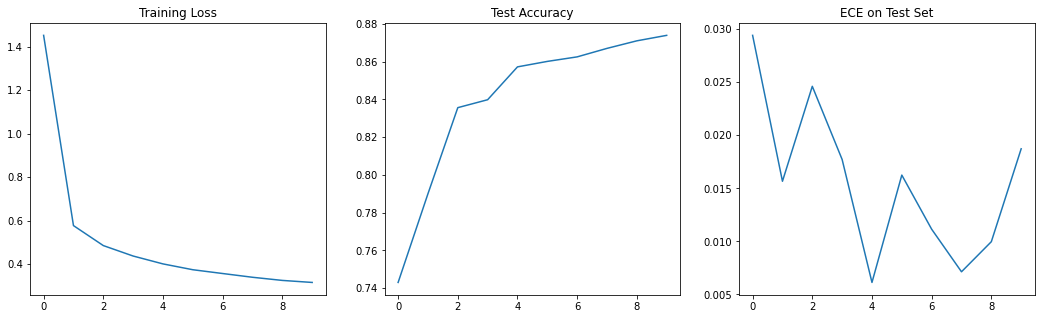

In [6]:
plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.plot(loss_list)
plt.title("Training Loss")
plt.subplot(1,3,2)
plt.plot(acc_list)
plt.title("Test Accuracy")
plt.subplot(1,3,3)
plt.plot(ece_list)
plt.title("ECE on Test Set")
plt.show()

In [7]:
# ===================================================== #
# == migrate from base model, finetune and train flow = #
# ===================================================== #

sto_model_cfg = [
            ("normal", {"loc":1.0, "scale":0.5},  # the name of base distribution and parameters for that distribution
                [("affine", 1, {"learnable":True}), # the first stack of flows (type, depth, params)
                ("planar2d", 6, {"init_sigma":0.01})] # the second stack of flows (type, depth, params)
            ),
            (
                "normal", {"loc":1.0, "scale":0.5}, 
                [("affine", 1), 
                 ("planar", 6)]
            )
            ]
sto_model = StoLeNet(sto_cfg=sto_model_cfg).to(device)
sto_model.migrate_from_det_model(base_model)
det_params, sto_params = sto_model.det_and_sto_params()
optimizer = optim.Adam([
                {'params': det_params, 'lr': 1e-4},
                {'params': sto_params, 'lr': 1e-3}
            ])

In [8]:
num_epochs = 30
loss_list, ll_list, kl_list, acc_list, ece_list = [[] for _ in range(5)]
for epoch in range(num_epochs):
    sto_model.train()
    batch_loss, batch_ll, batch_kl = [[] for _ in range(3)]
    for img, label in trainloader:
        img, label = img.to(device), label.to(device)
        pred = sto_model(img)
        log_likelihood, kl = sto_model.calc_loss(pred, label)
        loss = -log_likelihood + kl / len(trainloader.dataset)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        batch_ll.append(log_likelihood.item()) 
        batch_kl.append(kl.item()/ len(trainloader.dataset))
    avg = lambda l: sum(l)/len(l)
    avg_loss, avg_ll, avg_kl = avg(batch_loss), avg(batch_ll), avg(batch_kl)
    sto_acc = compute_accuracy(sto_model, testloader)
    sto_ece = compute_ece_loss(sto_model, testloader)
    print("Sto Model Epoch {:.4f} Avg Loss {:.4f} Likelihood {:.4f} KL {:.4f} Acc {:.4f} ECE {:.4f}".format(
                        epoch, avg_loss, avg_ll, avg_kl,sto_acc, sto_ece))
    loss_list.append(avg_loss)
    ll_list.append(avg_ll)
    kl_list.append(avg_kl)
    acc_list.append(sto_acc)
    ece_list.append(sto_ece)

Sto Model Epoch 0.0000 Avg Loss 0.3507 Likelihood -0.3504 KL 0.0003 Acc 0.8803 ECE 0.0171
Sto Model Epoch 1.0000 Avg Loss 0.3089 Likelihood -0.3073 KL 0.0015 Acc 0.8810 ECE 0.0178
Sto Model Epoch 2.0000 Avg Loss 0.2967 Likelihood -0.2940 KL 0.0027 Acc 0.8813 ECE 0.0109
Sto Model Epoch 3.0000 Avg Loss 0.2889 Likelihood -0.2856 KL 0.0033 Acc 0.8814 ECE 0.0225
Sto Model Epoch 4.0000 Avg Loss 0.2809 Likelihood -0.2773 KL 0.0036 Acc 0.8822 ECE 0.0148
Sto Model Epoch 5.0000 Avg Loss 0.2747 Likelihood -0.2710 KL 0.0037 Acc 0.8866 ECE 0.0076
Sto Model Epoch 6.0000 Avg Loss 0.2658 Likelihood -0.2621 KL 0.0037 Acc 0.8863 ECE 0.0089
Sto Model Epoch 7.0000 Avg Loss 0.2602 Likelihood -0.2565 KL 0.0037 Acc 0.8886 ECE 0.0108
Sto Model Epoch 8.0000 Avg Loss 0.2549 Likelihood -0.2512 KL 0.0037 Acc 0.8879 ECE 0.0224
Sto Model Epoch 9.0000 Avg Loss 0.2484 Likelihood -0.2447 KL 0.0037 Acc 0.8893 ECE 0.0208
Sto Model Epoch 10.0000 Avg Loss 0.2426 Likelihood -0.2389 KL 0.0036 Acc 0.8907 ECE 0.0214
Sto Model

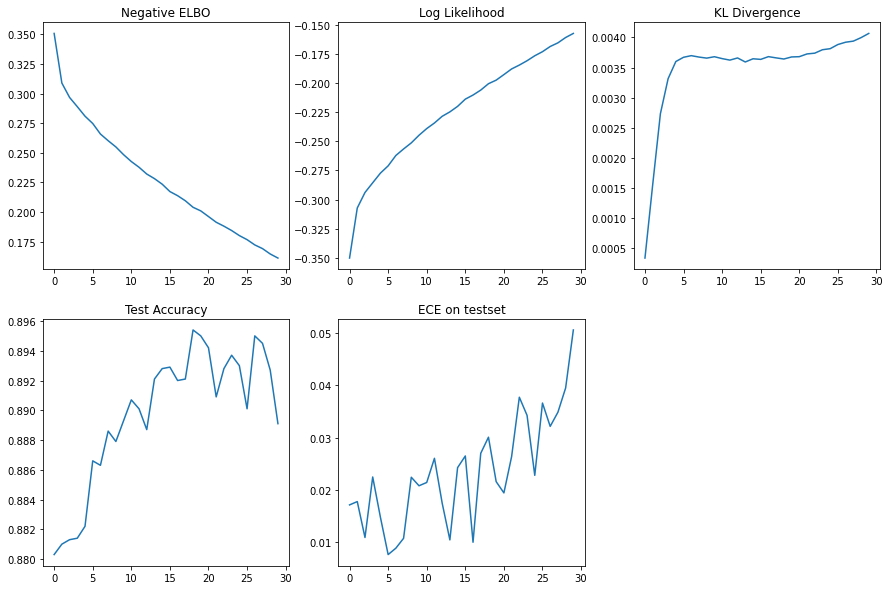

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.plot(loss_list)
plt.title("Negative ELBO")
plt.subplot(2,3,2)
plt.plot(ll_list)
plt.title("Log Likelihood")
plt.subplot(2,3,3)
plt.plot(kl_list)
plt.title("KL Divergence")
plt.subplot(2,3,4)
plt.plot(acc_list)
plt.title("Test Accuracy")
plt.subplot(2,3,5)
plt.plot(ece_list)
plt.title("ECE on testset")
plt.show()